In [ ]:
from __future__ import annotations
import warnings
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")


In [ ]:
def load_emissions(start_year: int = 1965) -> pd.Series:
    cols = ["country", "year", "greenhouse_gas_emissions"]
    df = (
        pd.read_csv(Path("..") / "data" / "World Energy Consumption.csv", usecols=cols)
          .query("country == 'New Zealand' and year >= @start_year")
          .dropna(subset=["greenhouse_gas_emissions"])
          .set_index("year")
          .sort_index()
    )
    df.index = pd.to_datetime(df.index.astype(str), format="%Y")
    return df["greenhouse_gas_emissions"]

emissions = load_emissions()
emissions.head()


year
2000-01-01    7.74
2001-01-01    9.54
2002-01-01    8.24
2003-01-01    9.05
2004-01-01    7.95
Name: greenhouse_gas_emissions, dtype: float64


Period: 2000–2022
Observations: 23
 count    23.000000
mean      7.346957
std       1.797755
min       4.310000
25%       5.780000
50%       7.740000
75%       8.645000
max       9.960000
Name: greenhouse_gas_emissions, dtype: float64 



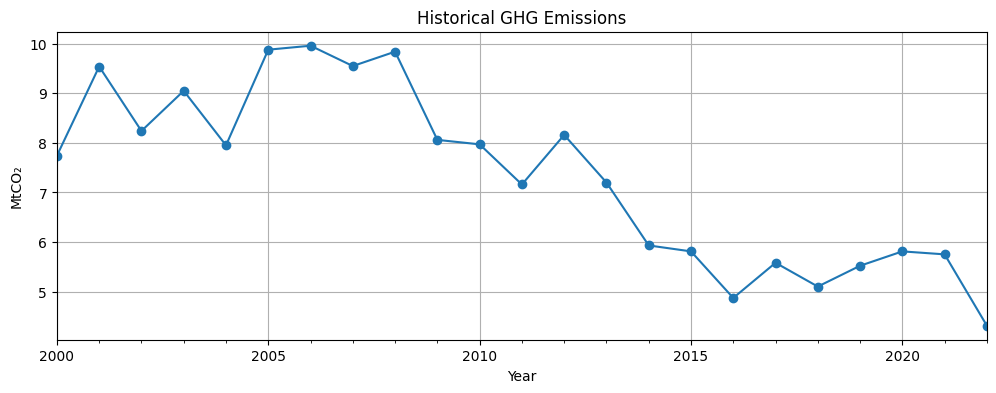

In [ ]:
def analyze_series(series: pd.Series):
    print(f"\nPeriod: {series.index.year.min()}–{series.index.year.max()}")
    print(f"Observations: {len(series)}\n", series.describe(), "\n")
    if len(series) >= 24:
        result = seasonal_decompose(series, model="additive", period=1)
        result.plot()
        plt.suptitle("Seasonal Decomposition")
        plt.tight_layout()
        plt.show()
    plt.figure(figsize=(12,4))
    series.plot(marker="o", title="Historical GHG Emissions")
    plt.xlabel("Year"); plt.ylabel("MtCO₂"); plt.grid(True); plt.show()

analyze_series(emissions)


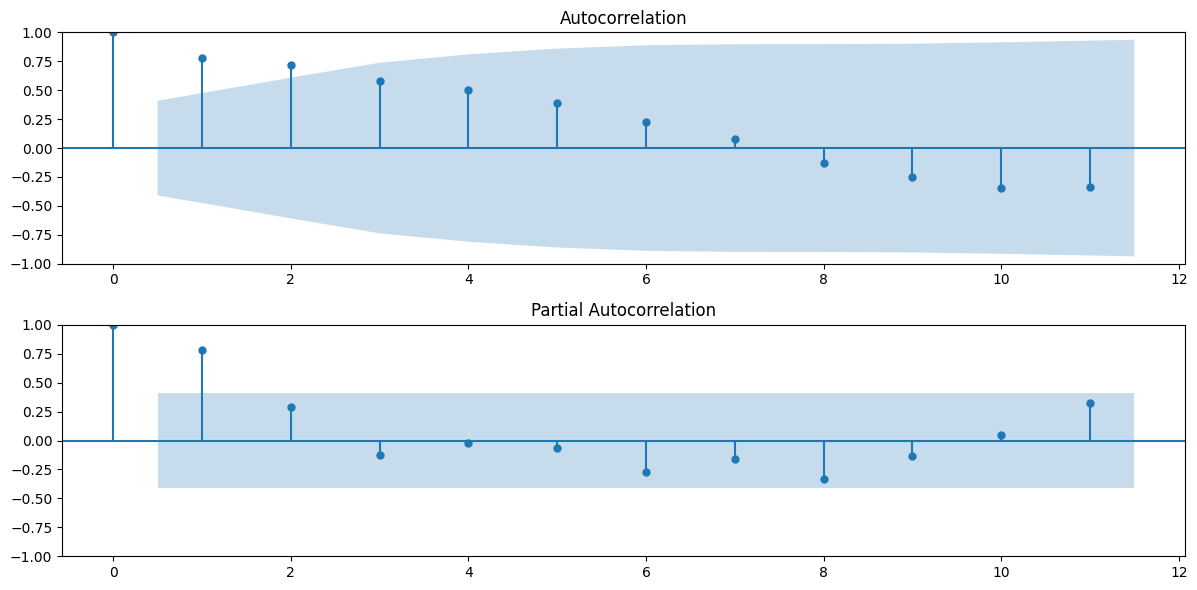

ADF Stat: -6.346, p-value: 0.000
  1%: -4.069
  5%: -3.127
  10%: -2.702
Stationary? True


In [ ]:
def check_stationarity(series: pd.Series) -> bool:
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,6))
    plot_acf(series.dropna(), ax=ax1, lags=min(20,len(series)//2))
    plot_pacf(series.dropna(), ax=ax2, lags=min(20,len(series)//2))
    plt.tight_layout(); plt.show()
    adf_res = adfuller(series.dropna())
    print(f"ADF Stat: {adf_res[0]:.3f}, p-value: {adf_res[1]:.3f}")
    for k,v in adf_res[4].items():
        print(f"  {k}: {v:.3f}")
    return adf_res[1] < 0.05

is_stationary = check_stationarity(emissions)
print("Stationary?", is_stationary)


In [ ]:
def fit_sarimax(y: pd.Series, order: Tuple[int,int,int]) -> SARIMAX:
    m = SARIMAX(y, order=order,
                enforce_stationarity=False,
                enforce_invertibility=False)
    return m.fit(disp=False)

def rolling_cv(y: pd.Series, order: Tuple[int,int,int], splits: int = 5):
    tss = TimeSeriesSplit(n_splits=splits)
    maes, rmses = [], []
    for tr, te in tss.split(y):
        m = fit_sarimax(y.iloc[tr], order)
        pred = m.get_forecast(steps=len(te)).predicted_mean
        maes.append(mean_absolute_error(y.iloc[te], pred))
        rmses.append(np.sqrt(mean_squared_error(y.iloc[te], pred)))
    return np.mean(maes), np.mean(rmses)

order = (1,1,1)   # adjust after ACF/PACF
mae_cv, rmse_cv = rolling_cv(emissions, order)
print(f"Rolling CV MAE={mae_cv:.2f}, RMSE={rmse_cv:.2f}")


Rolling CV MAE=0.93, RMSE=0.99


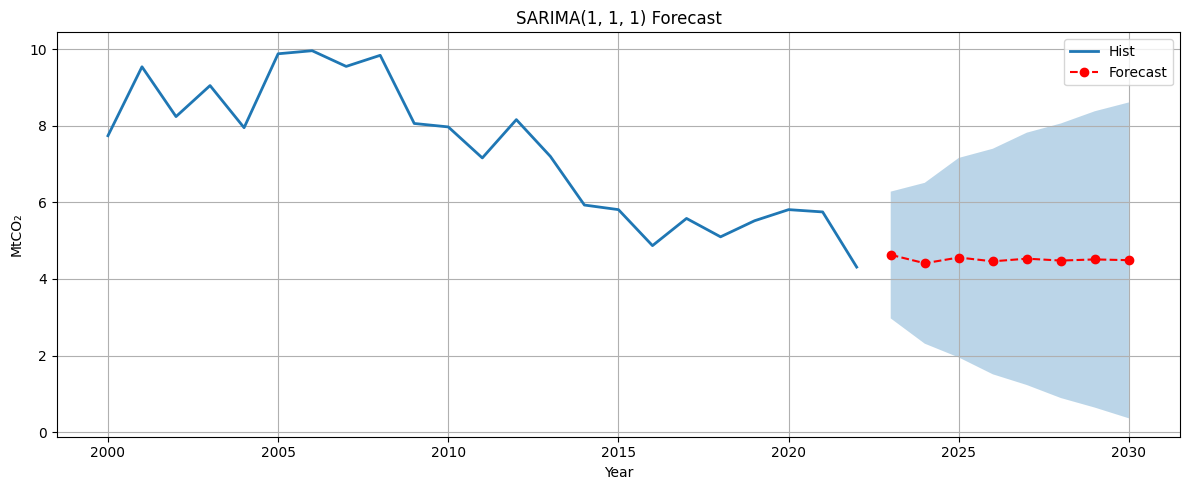

,year,forecast,lower_95,upper_95
2023-01-01,2023,4.63,2.97,6.28
2024-01-01,2024,4.41,2.31,6.51
2025-01-01,2025,4.56,1.95,7.16
2026-01-01,2026,4.46,1.51,7.40
2027-01-01,2027,4.53,1.23,7.82
2028-01-01,2028,4.48,0.89,8.06
2029-01-01,2029,4.51,0.64,8.38
2030-01-01,2030,4.49,0.36,8.61


In [ ]:
def forecast_series(series: pd.Series, order: Tuple[int,int,int], horizon: int=8):
    m = fit_sarimax(series, order)
    fc = m.get_forecast(steps=horizon)
    mean = fc.predicted_mean; ci = fc.conf_int()
    out = pd.DataFrame({
        "year": mean.index.year,
        "forecast": mean.round(2),
        "lower_95": ci.iloc[:,0].round(2),
        "upper_95": ci.iloc[:,1].round(2),
    })
    plt.figure(figsize=(12,5))
    plt.plot(series.index.year, series, label="Hist", lw=2)
    plt.plot(out.year, out.forecast, "ro--", label="Forecast")
    plt.fill_between(out.year, out.lower_95, out.upper_95, alpha=0.3)
    plt.title(f"SARIMA{order} Forecast"); plt.xlabel("Year"); plt.ylabel("MtCO₂")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    return out

fc_df = forecast_series(emissions, order)
fc_df


Horizon 5: MAE=0.41, RMSE=0.55, MAPE=8.52%, CI cov=100.0%


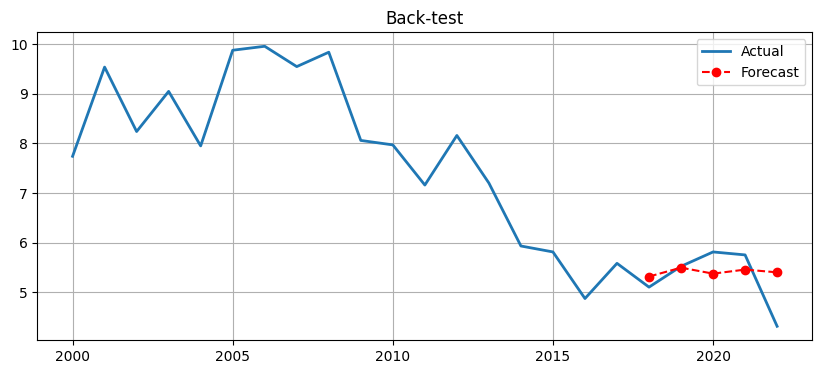

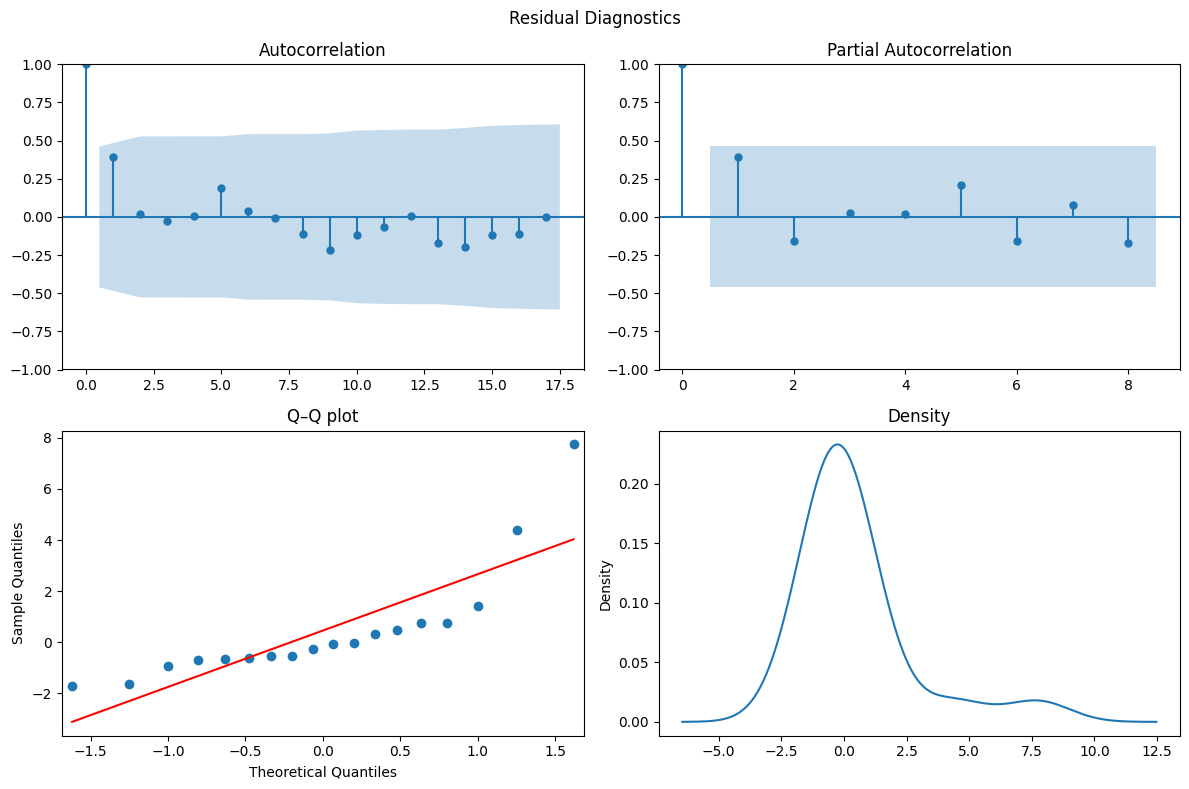

Ljung–Box (null: no autocorrelation):
     lb_stat  lb_pvalue
10    7.174      0.709
15   14.831      0.464
Horizon 5: MAE=0.41, RMSE=0.55, MAPE=8.52%, CI cov=100.0%


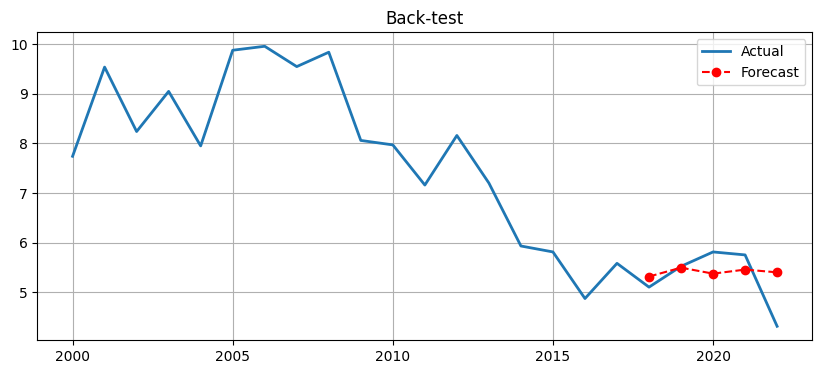

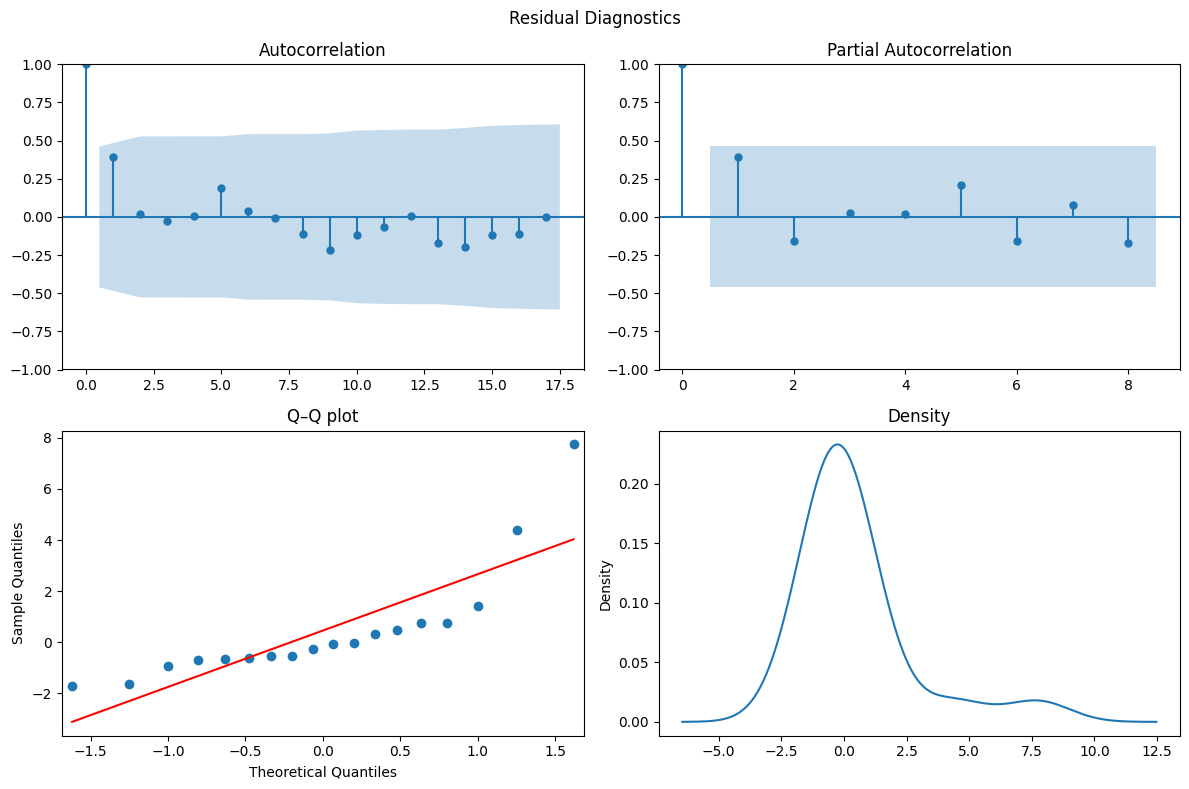

Ljung–Box (null: no autocorrelation):
     lb_stat  lb_pvalue
10    7.174      0.709
15   14.831      0.464


In [ ]:
def holdout_evaluate(series, order, horizon=5):
    train, test = series.iloc[:-horizon], series.iloc[-horizon:]
    m = fit_sarimax(train, order)
    fc = m.get_forecast(steps=horizon)
    pred = fc.predicted_mean
    ci = fc.conf_int()
    
    mae   = mean_absolute_error(test, pred)
    rmse  = np.sqrt(mean_squared_error(test, pred))
    mape  = np.mean(np.abs((test - pred) / test)) * 100
    coverage = np.mean((test >= ci.iloc[:,0]) & (test <= ci.iloc[:,1])) * 100

    print(f"Horizon {horizon}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%, CI cov={coverage:.1f}%")

    # Back-test plot
    plt.figure(figsize=(10,4))
    plt.plot(series.index.year, series, label="Actual", lw=2)
    plt.plot(test.index.year, pred, "ro--", label="Forecast")
    plt.title("Back-test"); plt.legend(); plt.grid(True); plt.show()

    # Residual diagnostics
    resid = m.resid
    nobs = len(resid)
    max_acf = min(20, nobs - 1)
    max_pacf = min(max_acf, max(1, nobs // 2 - 1))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sm.graphics.tsa.plot_acf(resid, lags=max_acf, ax=axes[0,0])
    sm.graphics.tsa.plot_pacf(resid, lags=max_pacf, ax=axes[0,1])
    sm.qqplot(resid, line="s", ax=axes[1,0]); axes[1,0].set_title("Q–Q plot")
    resid.plot(kind="kde", ax=axes[1,1]); axes[1,1].set_title("Density")
    plt.suptitle("Residual Diagnostics"); plt.tight_layout(); plt.show()

    # Ljung–Box at lags that actually exist
    lbs = [lag for lag in (10, 15, 20) if lag < nobs]
    lb_tbl = sm.stats.acorr_ljungbox(resid, lags=lbs, return_df=True)
    print("Ljung–Box (null: no autocorrelation):\n", lb_tbl.round(3))

    train, test = series.iloc[:-horizon], series.iloc[-horizon:]
    m = fit_sarimax(train, order)
    fc = m.get_forecast(steps=horizon)
    pred = fc.predicted_mean
    ci = fc.conf_int()
    mae   = mean_absolute_error(test, pred)
    rmse  = np.sqrt(mean_squared_error(test, pred))
    mape  = np.mean(np.abs((test - pred) / test)) * 100
    coverage = np.mean((test >= ci.iloc[:,0]) & (test <= ci.iloc[:,1])) * 100

    print(f"Horizon {horizon}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%, CI cov={coverage:.1f}%")

    # Back-test plot
    plt.figure(figsize=(10,4))
    plt.plot(series.index.year, series, label="Actual", lw=2)
    plt.plot(test.index.year, pred, "ro--", label="Forecast")
    plt.title("Back-test"); plt.legend(); plt.grid(True); plt.show()

    # Residuals
    resid = m.resid
    nobs = len(resid)

    # ACF can go up to nobs−1 (but cap at 20)
    acf_lags  = min(20, nobs - 1)
    # PACF must be < nobs/2, so use floor(nobs/2)−1, and at least 1
    pacf_lags = max(1, min(acf_lags, nobs//2 - 1))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sm.graphics.tsa.plot_acf(resid,  lags=acf_lags,  ax=axes[0,0])
    sm.graphics.tsa.plot_pacf(resid, lags=pacf_lags, ax=axes[0,1])
    sm.qqplot(resid, line="s",               ax=axes[1,0]); axes[1,0].set_title("Q–Q plot")
    resid.plot(kind="kde", ax=axes[1,1]);     axes[1,1].set_title("Density")
    plt.suptitle("Residual Diagnostics"); plt.tight_layout(); plt.show()

    # Ljung–Box only at lags that exist
    lbs = [lag for lag in (10,15,20) if lag < nobs]
    lb_tbl = sm.stats.acorr_ljungbox(resid, lags=lbs, return_df=True)
    print("Ljung–Box (null: no autocorrelation):\n", lb_tbl.round(3))


holdout_evaluate(emissions, order)
